In [1]:
%run ./Definitions.ipynb

2019-12-24 18:14:35.461123
thunder  Tue Dec 24 18:14:35 2019
[0] GeForce GTX 1080 Ti | 44'C,   0 % | 10895 / 11178 MB | patra(10885M)
[1] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[2] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[3] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 23'C,   0 % |    10 / 11178 MB |
[5] GeForce GTX 1080 Ti | 27'C,   0 % |    10 / 11178 MB |
[6] GeForce GTX 1080 Ti | 29'C,   0 % |    10 / 11178 MB |
[7] GeForce GTX 1080 Ti | 28'C,   0 % |    10 / 11178 MB |


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!



In [2]:
!nvidia-smi
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "1"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K

Tue Dec 24 18:14:48 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 30%   45C    P2    77W / 250W |  10895MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 29%   25C    P8     7W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# Converting class values to int 1 or 0
y_train = y_train.astype(int)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]==0]
glaucoma = X[X[Class]==1]

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# Converting class values to int 1 or 0
upsampled[Class] = upsampled[Class].astype(int)

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [8]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

In [9]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

## Define Model and Metrics

In [10]:
# reg_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # 1e-1, 
reg_value = 0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:81]:
        layer.trainable = False
    for layer in mobile_conv.layers[81:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
    
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [11]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

In [12]:
valid_traindf_names[Class] = valid_traindf_names[Class].astype(int)
valid_valdf_names[Class] = valid_valdf_names[Class].astype(int)

In [13]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True, rescale= 1./255) 
val_datagen = ImageDataGenerator(samplewise_center=True, rescale=1./255)  
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)


Found 198910 validated image filenames.
Found 33943 validated image filenames.


In [14]:
# which_model = make_model
which_model = mobilenet_model
# which_model = vgg_model
model = which_model()

learning_rate  = 0.0001 
decay = 1e-5
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,062,913
Non-trainable params: 2,166,976
_________________________________________________________________


In [15]:
# With L2 weight regularizer
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.000001, verbose=1)
keras_model_path = funduspath_CR + 'Models/'
n_epochs=150
n_steps_per_epoch = 50
n_validation_steps = 10

In [16]:
start = time.time()
history = model.fit_generator(train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/150
50/50 [==============================] - 51s 1s/step - loss: 0.6922 - Accuracy: 0.5900 - Precision: 0.5797 - Recall: 0.6098 - F1: 0.5868 - AUC: 0.6222 - val_loss: 0.7651 - val_Accuracy: 0.3969 - val_Precision: 0.0255 - val_Recall: 0.5000 - val_F1: 0.0484 - val_AUC: 0.7273
Epoch 2/150
50/50 [==============================] - 52s 1s/step - loss: 0.6608 - Accuracy: 0.6169 - Precision: 0.6154 - Recall: 0.6071 - F1: 0.6012 - AUC: 0.6691 - val_loss: 0.8694 - val_Accuracy: 0.3344 - val_Precision: 0.0312 - val_Recall: 0.5500 - val_F1: 0.0588 - val_AUC: 0.6152
Epoch 3/150
50/50 [==============================] - 51s 1s/step - loss: 0.6612 - Accuracy: 0.6175 - Precision: 0.6164 - Recall: 0.5952 - F1: 0.5979 - AUC: 0.6743 - val_loss: 0.3911 - val_Accuracy: 0.9531 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6827
Epoch 4/150
50/50 [==============================] - 51s 1s/step - loss: 0.6647 - Accuracy: 0.5981 - Precision: 0.5981 - Recall: 0.62

Epoch 29/150
50/50 [==============================] - 51s 1s/step - loss: 0.5776 - Accuracy: 0.6963 - Precision: 0.6955 - Recall: 0.7168 - F1: 0.6985 - AUC: 0.7662 - val_loss: 0.7422 - val_Accuracy: 0.6062 - val_Precision: 0.0398 - val_Recall: 0.1833 - val_F1: 0.0645 - val_AUC: 0.5609
Epoch 30/150
50/50 [==============================] - 51s 1s/step - loss: 0.5759 - Accuracy: 0.6988 - Precision: 0.7112 - Recall: 0.7220 - F1: 0.7097 - AUC: 0.7665 - val_loss: 0.5241 - val_Accuracy: 0.6844 - val_Precision: 0.0416 - val_Recall: 0.2333 - val_F1: 0.0694 - val_AUC: 0.6328
Epoch 31/150
50/50 [==============================] - 50s 1s/step - loss: 0.5958 - Accuracy: 0.6825 - Precision: 0.6784 - Recall: 0.7109 - F1: 0.6872 - AUC: 0.7474 - val_loss: 0.5007 - val_Accuracy: 0.6187 - val_Precision: 0.0401 - val_Recall: 0.3500 - val_F1: 0.0702 - val_AUC: 0.5990
Epoch 32/150
50/50 [==============================] - 50s 1s/step - loss: 0.5696 - Accuracy: 0.6969 - Precision: 0.6800 - Recall: 0.7309 - F1:

50/50 [==============================] - 48s 970ms/step - loss: 0.5912 - Accuracy: 0.6827 - Precision: 0.6639 - Recall: 0.7178 - F1: 0.6822 - AUC: 0.7473 - val_loss: 0.5990 - val_Accuracy: 0.6875 - val_Precision: 0.0523 - val_Recall: 0.3000 - val_F1: 0.0874 - val_AUC: 0.5813
Epoch 58/150
50/50 [==============================] - 46s 930ms/step - loss: 0.5887 - Accuracy: 0.6875 - Precision: 0.6742 - Recall: 0.7097 - F1: 0.6872 - AUC: 0.7535 - val_loss: 0.7369 - val_Accuracy: 0.6313 - val_Precision: 0.0425 - val_Recall: 0.3500 - val_F1: 0.0749 - val_AUC: 0.7109
Epoch 59/150
50/50 [==============================] - 48s 962ms/step - loss: 0.5581 - Accuracy: 0.7237 - Precision: 0.7208 - Recall: 0.7557 - F1: 0.7316 - AUC: 0.7889 - val_loss: 0.6127 - val_Accuracy: 0.6344 - val_Precision: 0.0495 - val_Recall: 0.3167 - val_F1: 0.0839 - val_AUC: 0.6088
Epoch 60/150
50/50 [==============================] - 48s 960ms/step - loss: 0.5697 - Accuracy: 0.7219 - Precision: 0.7143 - Recall: 0.7413 - F1: 

50/50 [==============================] - 48s 956ms/step - loss: 0.5809 - Accuracy: 0.7031 - Precision: 0.6987 - Recall: 0.7319 - F1: 0.7069 - AUC: 0.7595 - val_loss: 0.6919 - val_Accuracy: 0.5906 - val_Precision: 0.0363 - val_Recall: 0.2500 - val_F1: 0.0618 - val_AUC: 0.6368
Epoch 86/150
50/50 [==============================] - 48s 952ms/step - loss: 0.5953 - Accuracy: 0.6806 - Precision: 0.6726 - Recall: 0.6969 - F1: 0.6773 - AUC: 0.7451 - val_loss: 0.6160 - val_Accuracy: 0.6125 - val_Precision: 0.0678 - val_Recall: 0.5500 - val_F1: 0.1184 - val_AUC: 0.6684
Epoch 87/150
50/50 [==============================] - 48s 952ms/step - loss: 0.5781 - Accuracy: 0.6906 - Precision: 0.6680 - Recall: 0.7248 - F1: 0.6880 - AUC: 0.7641 - val_loss: 0.5869 - val_Accuracy: 0.5688 - val_Precision: 0.0422 - val_Recall: 0.6000 - val_F1: 0.0784 - val_AUC: 0.6957
Epoch 88/150
50/50 [==============================] - 49s 973ms/step - loss: 0.5974 - Accuracy: 0.6925 - Precision: 0.6991 - Recall: 0.6995 - F1: 

50/50 [==============================] - 47s 948ms/step - loss: 0.5746 - Accuracy: 0.7000 - Precision: 0.6824 - Recall: 0.7281 - F1: 0.6972 - AUC: 0.7712 - val_loss: 0.7159 - val_Accuracy: 0.5312 - val_Precision: 0.0129 - val_Recall: 0.1333 - val_F1: 0.0230 - val_AUC: 0.4643
Epoch 114/150
50/50 [==============================] - 49s 975ms/step - loss: 0.5756 - Accuracy: 0.7081 - Precision: 0.6991 - Recall: 0.7269 - F1: 0.7061 - AUC: 0.7688 - val_loss: 0.6817 - val_Accuracy: 0.5906 - val_Precision: 0.0350 - val_Recall: 0.4000 - val_F1: 0.0641 - val_AUC: 0.7253
Epoch 115/150
50/50 [==============================] - 49s 977ms/step - loss: 0.5550 - Accuracy: 0.7231 - Precision: 0.7233 - Recall: 0.7479 - F1: 0.7274 - AUC: 0.7903 - val_loss: 0.6591 - val_Accuracy: 0.5750 - val_Precision: 0.0244 - val_Recall: 0.1500 - val_F1: 0.0418 - val_AUC: 0.6641
Epoch 116/150
50/50 [==============================] - 49s 976ms/step - loss: 0.5965 - Accuracy: 0.6800 - Precision: 0.6732 - Recall: 0.7140 - F

50/50 [==============================] - 48s 968ms/step - loss: 0.5719 - Accuracy: 0.6950 - Precision: 0.6869 - Recall: 0.7191 - F1: 0.6946 - AUC: 0.7711 - val_loss: 0.6736 - val_Accuracy: 0.6125 - val_Precision: 0.0268 - val_Recall: 0.4000 - val_F1: 0.0502 - val_AUC: 0.7107
Epoch 142/150
50/50 [==============================] - 48s 965ms/step - loss: 0.5721 - Accuracy: 0.7056 - Precision: 0.7012 - Recall: 0.7249 - F1: 0.7055 - AUC: 0.7768 - val_loss: 0.6390 - val_Accuracy: 0.6281 - val_Precision: 0.0714 - val_Recall: 0.6000 - val_F1: 0.1270 - val_AUC: 0.8076
Epoch 143/150
50/50 [==============================] - 48s 955ms/step - loss: 0.5742 - Accuracy: 0.7075 - Precision: 0.6771 - Recall: 0.7399 - F1: 0.7011 - AUC: 0.7709 - val_loss: 0.7271 - val_Accuracy: 0.5625 - val_Precision: 0.0133 - val_Recall: 0.1500 - val_F1: 0.0243 - val_AUC: 0.4289
Epoch 144/150
50/50 [==============================] - 48s 966ms/step - loss: 0.5752 - Accuracy: 0.6963 - Precision: 0.6938 - Recall: 0.7056 - F

In [17]:
print("Time taken:",end-start)

Time taken: 7342.257836818695


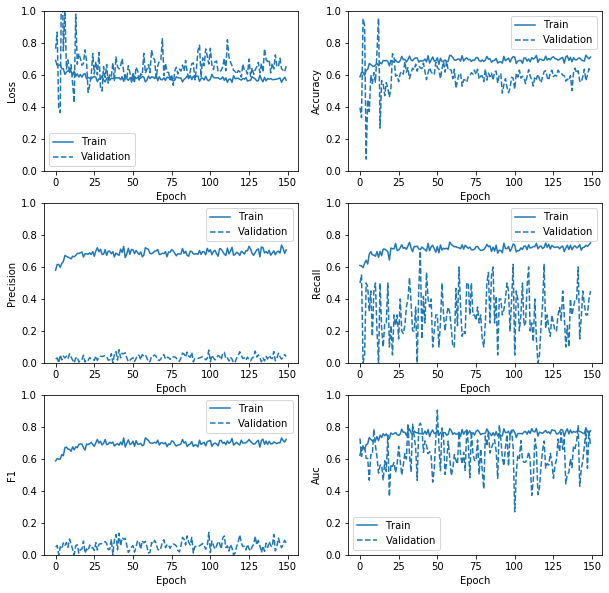

In [18]:
plt.figure(figsize=(10,10))
plot_metrics(history)

## Evaluation

In [19]:
results_tr = model.evaluate(train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 15s 150ms/step


In [20]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))


NAME :	TRAIN :	VALIDATION 
loss : 0.657 :   0.701
Accuracy : 0.575 :   0.625
Precision : 0.556 :   0.031
Recall : 0.735 :   0.232
F1 : 0.627 :   0.054
AUC : 0.616 :   0.572


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [21]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

(5951.6216776371, 151.88261222839355)

In [22]:
# TRUE LABELS

train_labels = upsampled[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


In [23]:
np.save(funduspath_CR + str(n_epochs) + 'ep_gap_pred_tr_81unfreze.npy', pred_tr)
np.save(funduspath_CR + str(n_epochs) + 'ep_gap_pred_vl_81unfreze.npy', pred_vl)

### ROC Curve

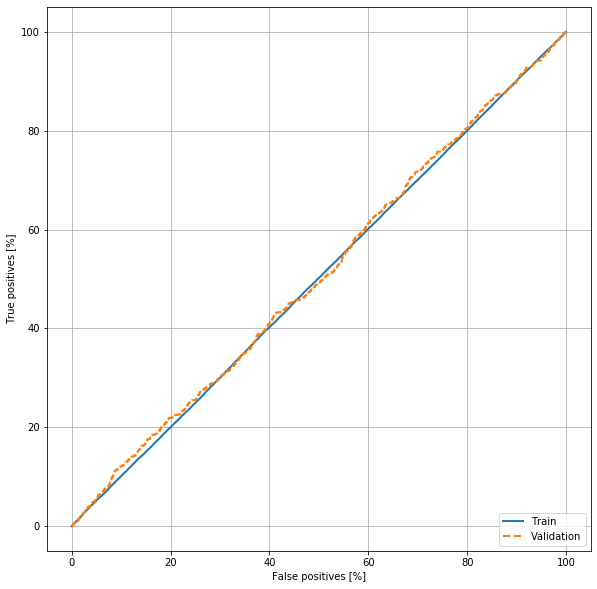

In [24]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 33811 
FP: 65644 
FN: 33641 
TP: 65814
Healthy Patients - correctly identified (True Negatives):  33811 0.3399627972449852
Healthy Patients - predicted to have glaucoma (False Positives):  65644 0.6600372027550149
Glaucoma Patients - predicted healthy (False Negatives):  33641 0.3382534814740335
Glaucoma Patients - correctly identified (True Positives):  65814 0.6617465185259666

Total Glaucoma patients:  99455 1.0
Total Healthy patients:  99455 1.0


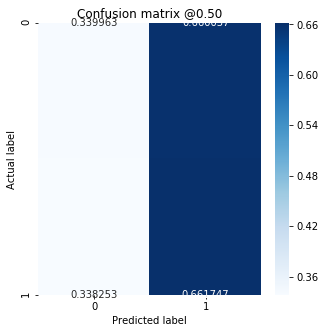

In [25]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(train_labels, pred_tr)

Validation data: 
TN: 20575 
FP: 12559 
FN: 495 
TP: 314
Healthy Patients - correctly identified (True Negatives):  20575 0.6209633608981711
Healthy Patients - predicted to have glaucoma (False Positives):  12559 0.37903663910182894
Glaucoma Patients - predicted healthy (False Negatives):  495 0.6118665018541409
Glaucoma Patients - correctly identified (True Positives):  314 0.38813349814585907

Total Glaucoma patients:  809 1.0
Total Healthy patients:  33134 1.0


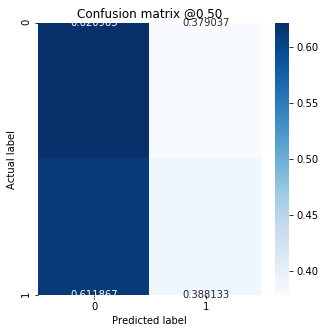

In [26]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(val_labels, pred_vl)

In [29]:
get_notebook_name()

<IPython.core.display.Javascript object>

'CNN Fundus- RUN1-Copy2.ipynb'

### MLFlow 

In [30]:
# # history = imb_history
# tag_value = "single train RUN1-Copy2 with samplewise_center = True"
# myname = get_notebook_name()
# exp_name = myname +"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
# keras_model_path = funduspath_CR+ exp_name + '_model'
# save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
#             n_epochs,n_steps_per_epoch,n_validation_steps,
#             reg_value,learning_rate,decay,opt,
#             history,results_tr,results_vl,train_cm,val_cm
#            )

<IPython.core.display.Javascript object>

In [31]:
# client = MlflowClient()
# run = client.create_run('24')
# client.set_tag(run.info.run_id, "tag_key", tag_value)